In [379]:
#
# 単純移動平均, 指数移動平均, ボリジャーバンド 
#
%matplotlib inline
import math
import datetime
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

In [387]:
client = pymongo.MongoClient('mongodb://ec2-54-250-245-71.ap-northeast-1.compute.amazonaws.com:27017/bitflyer')
db = client.bitflyer
co = db.lightning_executions_FX_BTC_JPY_OHLC_3600
#co = db.lightning_executions_BTC_JPY_OHLC_86400

In [396]:
date = []
quote = [] #ローソク足

sma15 = [] #単純移動平均 15日
sma20 = [] #単純移動平均 20日
sma50 = [] #単純移動平均 50日
ema10 = [] #指数移動平均 10日
ema21 = [] #指数移動平均 21日
bolbupper = [] #ボリジャー上部バンド
bolblower = [] #ボリジャー下部バンド

edge_date = [] #チャートの山、谷
edge_price = []

trend_date = [] #トレンド決定
trend_price = []

#直近のcount件のデータを処理
count = 200
skip = 0
if (co.count() > count):
    skip = co.count() - count
else:
    count = co.count()

hist10 = [] #過去10期間のヒストリ
hist15 = [] #過去15期間のヒストリ
hist20 = [] #過去20期間のヒストリ
hist50 = [] #過去50期間のヒストリ

#チャートの山、谷、トレンドの検出用
direct = None #チャート進行方向 (UP/DOWN)
direct_fail = 0 #チャート進行方向の転換検出
last_data = None #直近データ
head_data = None #山の頂上
bottom_data = None #谷の底
head_list= []
bottom_list = []
top = 'hi'  # 'hi' or 'op'
bottom = 'lo'  # 'lo' or 'cl'
trend = None

def detectTrend(trend, direct, head_list, bottom_list, data):
    
    if (len(head_list)>0 and len(bottom_list)>1):
        if (trend != 'UP' and direct == 'up'):
            if (head_list[-1][top] < data[top] and bottom_list[-2][bottom] < bottom_list[-1][bottom]):
                print 'UP ', data['op_date']
                trend = 'UP'
                trend_date.append(date2num(data['op_date']))
                trend_price.append(head_list[-1][top])
                    
    if (len(head_list)>1 and len(bottom_list)>0):
        if (trend != 'DOWN' and direct == 'down'):
            if (bottom_list[-1][bottom] > data[bottom] and head_list[-2][top] > head_list[-1][top]):
                print 'DOWN ', data['op_date']
                trend = 'DOWN'
                trend_date.append(date2num(data['op_date']))
                trend_price.append(bottom_list[-1][bottom])
                
    return trend

for data in co.find({}).skip(skip).sort('id',1):
    
    # ローソク足チャート用のデータ
    t = data['op_date']
    date.append(t)
    quote.append((date2num(t), data['op'], data['cl'], data['hi'], data['lo']))
    
    # ヒストリに追加
    if (len(hist10)==10):
        hist10.pop(0)
    if (len(hist15)==15):
        hist15.pop(0)
    if (len(hist20)==20):
        hist20.pop(0)
    if (len(hist50)==50):
        hist50.pop(0)
    hist10.append(data['cl'])
    hist15.append(data['cl'])
    hist20.append(data['cl'])
    hist50.append(data['cl'])
    
    # 単純移動平均
    sma15.append(sum(hist15)/len(hist15))
    sma20.append(sum(hist20)/len(hist20))
    sma50.append(sum(hist50)/len(hist50))
    
    # 指数移動平均
    if (len(ema10)<10):
        ema10.append(sum(hist10)/len(hist10))
    else:
        pre = ema10[len(ema10)-1]
        k = 2.0 / (10.0+1.0)
        ema10.append((data['cl'] - pre) * k  + pre)
        
    if (len(ema21)<10):
        ema21.append(sum(hist10)/len(hist10))
    else:
        pre = ema21[len(ema21)-1]
        k = 2.0 / (21.0+1.0)
        ema21.append((data['cl'] - pre) * k + pre)
    
    # ボリジャーバンド
    if (len(hist20) == 20):
        sigma = math.sqrt((20.0 * sum(np.power(hist20, 2)) - (sum(hist20)**2.0)) / (20.0 * (20.0 - 1.0)))
        bolbupper.append(sma20[len(sma20)-1] + 2.0 * sigma)
        bolblower.append(sma20[len(sma20)-1] - 2.0 * sigma)
    
    #チャートの山、谷の検出
    if (last_data is None):
        if (data['op'] < data['cl']):
            direct = 'up'
            head_data = data
            bottom_data = data
        else:
            direct = 'down'
            head_data = data
            bottom_data = data
    else:
                    
        if (direct=='up' and head_data[top] > data[top]):
            # 上ヒゲ更新に2回連続で失敗
            direct_fail += 1
            if (direct_fail == 2):
                edge_date.append(date2num(head_data['op_date']))
                edge_price.append(head_data[top])
                #print 'head ', head_data['op_date'], ' ', data['op_date']
                head_list.append(head_data)
                direct_fail = 0
                direct = 'down'
                if (last_data[bottom] > data[bottom]):
                    bottom_data = data
                else:
                    bottom_data = last_data
                    direct_fail = 1
                
        elif (direct=='down' and bottom_data[bottom] < data[bottom]):
            # 下ヒゲ更新に2回連続で失敗
            direct_fail += 1
            if (direct_fail == 2):
                edge_date.append(date2num(bottom_data['op_date']))
                edge_price.append(bottom_data[bottom])
                #print 'bottom ', bottom_data['op_date'], ' ', data['op_date']
                bottom_list.append(bottom_data)
                direct_fail = 0
                direct = 'up'
                if (last_data[top] < data[top]):
                    head_data = data
                else:
                    head_data = last_data
                    direct_fail = 1
        else:
            direct_fail = 0
                    
        if (direct=='up'):
            if (head_data is not None):
                if (head_data[top] < data[top]):
                    head_data = data
            else:
                head_data = data
                
        if (direct=='down'):
            if (bottom_data is not None):
                if (bottom_data[bottom] > data[bottom]):
                    bottom_data = data
            else:
                bottom_data = data
            
    last_data = data
    
    #トレンド検出
    trend = detectTrend(trend, direct, head_list, bottom_list, data)
            
        

DOWN  2017-06-24 14:00:00.060000
UP  2017-06-25 05:00:01.507000
DOWN  2017-06-25 18:00:02.720000
UP  2017-06-26 20:00:01.960000
DOWN  2017-06-27 04:00:00.913000
UP  2017-06-28 20:00:02.637000
DOWN  2017-06-29 01:00:01.820000
UP  2017-06-29 09:00:00.080000
DOWN  2017-06-29 21:00:00.020000


In [397]:
# figure_width := ローソク足チャート全体の幅 (単位:日)
# candle_width := ローソクの幅 (単位:日)
delta = date[-1] - date[0]
figure_width = delta.total_seconds()/(60*60*24)
candle_width = 0.6 * figure_width / count;

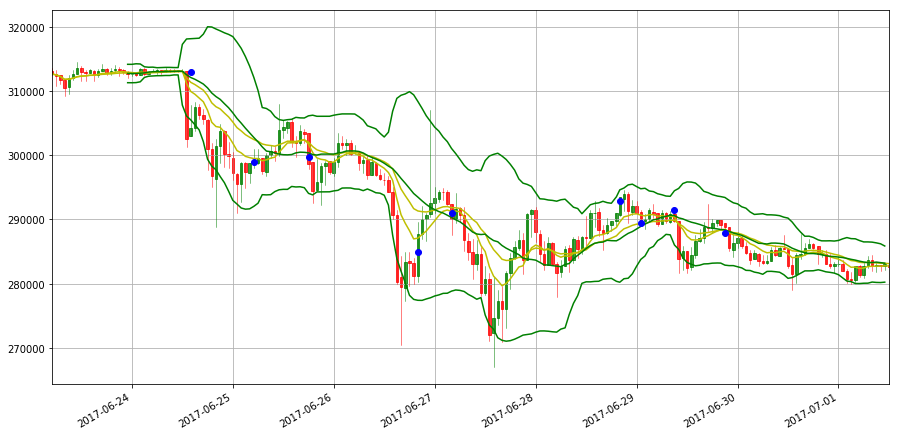

200

In [398]:
# ローソク足チャートを描く
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.grid()
ax.set_xlim(date[0], date[-1])
mf.candlestick_ochl(ax, quote, width=candle_width, colorup='g', colordown='r', alpha=0.75)
#ax.plot(date, sma15, color='b')
#ax.plot(date, sma50, color='b')
ax.plot(date, ema10, color='y')
ax.plot(date, ema21, color='y')
ax.plot(date[18:-1], bolbupper, color='g')
ax.plot(date[18:-1], bolblower, color='g')
ax.plot(date[18:-1], sma20[18:-1], color='g')
#ax.plot(edge_date, edge_price, "o", color='b')
ax.plot(trend_date, trend_price, "o", color='b')
fig.autofmt_xdate()
plt.show()
len(date)